# Capstone Project - Germany  


In the previous examples, we looked at comparing neighbourhoods from Toronto or New York. Big cities with huge skyscrapers and god knows, those are beautiful places to live. But what about the districts in southern Germany, where I come from. I want to apply the lessons learned in a more rural context. Which districts are similar, which districts have most inhabitants and so on. As there is a need for a direct problem statement, I will try to find a good place to build a fitness centre. 
	

First, lets import the libraries

In [236]:
import warnings                             # to ignore warnings
warnings.filterwarnings('ignore')
import time
import requests                             # library to handle requests
import json                                 # library to handle JSON file
import folium                               # map rendering library
import numpy as np                          # numeric library
import pandas as pd                         # library for data analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from pandas.io.json import json_normalize   # tranform JSON file into a pandas datafram
import matplotlib.pyplot as mpp
import seaborn as sb
from bs4 import BeautifulSoup               # for scraping web pages
from geopy.geocoders import Nominatim       # convert an address into latitude and longitude values
from sklearn.cluster import KMeans          # clustering model
# Define Foursquare accounts
CLIENT_ID = '51XHGE1T5XDX0LJ1NS5YDWCEK2QT2NK3KF2BKSA5PLA1JPKB'
CLIENT_SECRET = 'GQJ3FIKNEVYMZJH00NSS0KAEBPPEMCBJWHZEW4OLTSACG0S3'
VERSION = '20200322'
limit = 500

Next cell contains functions used later in the Notebook

In [237]:
# I wanted to rewrite the function to include a polygon ... thats pretty cool. came from 
# https://stackoverflow.com/questions/40547893/four-square-venues-in-side-custom-shapes-on-google-maps-in-ios-swift/40554407#40554407?newreg=780d5d4d55b44abf9794ea7e95bbb3ee
#  but that did not work :()

# chaged it to read back only with a query.

def getNearbyVenues(names, latitudes, longitudes, radius=10000 ,query="Tankstelle"):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit,
            query)
            
        # make the GET request
        #print(url)
        results = requests.get(url).json()["response"]
        
        if 'groups' in results:
            results = results['groups'][0]['items']# return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                ) for v in results])
        else:
            results = results['venues']
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['name'], 
                v['location']['lat'], 
                v['location']['lng'],  
               ) for v in results])
        


    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Community', 
                  'Community Latitude', 
                  'Community Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                ]
    
    return(nearby_venues)

# debug
#venues = getNearbyVenues(names=["Ravensburg"],latitudes=[47.969713],longitudes=[9.5])


In [265]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now lets first load the JSON File with the countys. Two files are loaded. One file has all the districts, the other has the local communities. 
I create a dictionary to lookup the correect district, as the id on properties.NUTS is the identifier for this matter.
After that, I create the rest of the data I want to use for further analysis

In [238]:
with open('gemeinden_simplify200(1).geojson', 'r', encoding='utf-8') as communities_data:
    communities_data = json.load(communities_data)

with open('landkreise_simplify200(1).geojson', 'r', encoding='utf-8') as districts_data:
    districts_data = json.load(districts_data)

In [239]:
featuresCommunities = communities_data['features']
communities = json_normalize(featuresCommunities)
featuresDistricts = districts_data['features']
districts = json_normalize(featuresDistricts)

code2district = pd.Series(districts["properties.GEN"].values,index = districts["properties.NUTS"].values).to_dict()
communities_df = pd.DataFrame()


communities_df["districtName"] = communities["properties.NUTS"].map(code2district)
communities_df["communityName"] = communities["properties.GEN"]
communities_df["latitude"] = communities["properties.destatis.center_lat"].apply(lambda x: x.replace(",",".")).astype(float)
communities_df["longitude"] = communities["properties.destatis.center_lon"].apply(lambda x: x.replace(",",".")).astype(float)
communities_df["population m"] = communities["properties.destatis.population_m"]
communities_df["population w"] = communities["properties.destatis.population_w"]
communities_df["geometry.coordinates"] = communities["properties.destatis.population"]
#communities_df["polygon"] = communities["geometry.coordinates"]

#communities_df.dtypes
communities_df.head()


#communities.head()

,districtName,communityName,latitude,longitude,population m,population w,geometry.coordinates
0,Ravensburg,Boms,47.969713,9.508511,338,326,664
1,Ravensburg,Ebenweiler,47.900658,9.513264,630,583,1213
2,Ravensburg,Eichstegen,47.938739,9.498845,254,252,506
3,Ravensburg,Fleischwangen,47.879063,9.477566,364,338,702
4,Ravensburg,Guggenhausen,47.893685,9.455438,88,101,189


In [240]:
print("There are {} communities in this data set".format(communities_df.shape[0]))
print("There are {} null/nan values".format(communities_df.isnull().sum().sum()))


There are 132 communities in this data set
There are 0 null/nan values


Now lets find out the most common venues on each community, but first I want to show a map to look if it was done correctly.


In [293]:
mapbw = folium.Map(location=[communities_df["latitude"].mean(),communities_df["longitude"].mean()],zoom_start=9)

for lat,lng,borough,neighbourhood in zip(communities_df['latitude'],communities_df['longitude'],communities_df['districtName'],communities_df['communityName']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(mapbw)
mapbw

In [242]:
print("Running...")
venues = getNearbyVenues(names=communities_df['communityName'],
                                   latitudes=communities_df['latitude'],
                                   longitudes=communities_df['longitude'], radius = 10000, query="Tankstelle")
print("Done...")

Boms
Ebenweiler
Eichstegen
Fleischwangen
Guggenhausen
Hoßkirch
Königseggwald
Riedhausen
Unterwaldhausen
Ebersbach-Musbach
Bad Waldsee
Ravensburg
Weingarten
Vogt
Wolfegg
Achberg
Amtzell
Wangen im Allgäu
Wilhelmsdorf
Horgenzell
Wolpertswende
Fronreute
Ostrach
Gammertingen
Hettingen
Neufra
Veringenstadt
Hohentengen
Mengen
Scheer
Leibertingen
Meßkirch
Sauldorf
Schemmerhofen
Alleshausen
Allmannsweiler
Bad Buchau
Betzenweiler
Dürnau
Kanzach
Moosburg
Oggelshausen
Seekirch
Tiefenbach
Bad Schussenried
Ingoldingen
Attenweiler
Biberach an der Riß
Eberhardzell
Hochdorf
Maselheim
Mittelbiberach
Ummendorf
Warthausen
Berkheim
Dettingen an der Iller
Erolzheim
Kirchberg an der Iller
Kirchdorf an der Iller
Achstetten
Burgrieden
Laupheim
Mietingen
Erlenmoos
Ochsenhausen
Steinhausen an der Rottum
Gutenzell-Hürbel
Altheim
Dürmentingen
Ertingen
Langenenslingen
Riedlingen
Unlingen
Uttenweiler
Rot an der Rot
Tannheim
Schwendi
Wain
Meckenbeuren
Eriskirch
Kressbronn am Bodensee
Langenargen
Friedrichshafen
Immen

In [251]:
venues.groupby('Community').count()

,Community Latitude,Community Longitude,Venue,Venue Latitude,Venue Longitude
Community,,,,,
Achberg,15,15,15,15,15
Achstetten,7,7,7,7,7
Aichstetten,2,2,2,2,2
Aitrach,3,3,3,3,3
Alleshausen,2,2,2,2,2
Allmannsweiler,6,6,6,6,6
Altheim,3,3,3,3,3
Altshausen,6,6,6,6,6
Amtzell,4,4,4,4,4


In [252]:
venues

,Community,Community Latitude,Community Longitude,Venue,Venue Latitude,Venue Longitude
0,Boms,47.969713,9.508511,kaufland,48.009297,9.504343
1,Boms,47.969713,9.508511,supermarkt,48.009297,9.504343
2,Boms,47.969713,9.508511,autowelt,48.010309,9.496515
3,Boms,47.969713,9.508511,jet,47.944321,9.636791
4,Boms,47.969713,9.508511,aral,48.019143,9.497020
5,Boms,47.969713,9.508511,jet,48.019145,9.492521
7,Ebenweiler,47.900658,9.513264,jet,47.944321,9.636791
9,Eichstegen,47.938739,9.498845,kaufland,48.009297,9.504343
10,Eichstegen,47.938739,9.498845,supermarkt,48.009297,9.504343
11,Eichstegen,47.938739,9.498845,jet,47.944321,9.636791


Seems like another round of data cleaning is required. The Venue names are not as good as I wish. So I start by removing the word "Tankstelle" and go from there

In [256]:
venues["Venue"]= venues["Venue"].apply(lambda x: x.replace("Tankstelle","").lower())
venues['Venue'].replace('', np.nan, inplace=True)
venues.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)



gas_Stations = ("esso", "agip", "ran", "avia", "bft", "shell", "sb","omv","aral","agip")
for index,row in venues.iterrows():
    venue = row["Venue"]
    found = False
    for gas_Station in gas_Stations:
        #print("Searching for: "+venue)
        if gas_Station in venue:
            #print(gas_Station)
            venues.at[index, "Venue"] =  gas_Station
            found = True
            #print("Replaced")
            break
    if not found:
        venues.drop(index,inplace=True)
venues.shape

(584, 6)

In [257]:
venues

,Community,Community Latitude,Community Longitude,Venue,Venue Latitude,Venue Longitude
4,Boms,47.969713,9.508511,aral,48.019143,9.497020
13,Eichstegen,47.938739,9.498845,aral,48.019143,9.497020
16,Fleischwangen,47.879063,9.477566,avia,47.796824,9.504685
23,Hoßkirch,47.940508,9.446033,aral,48.019143,9.497020
31,Ebersbach-Musbach,47.956209,9.580336,aral,48.019143,9.497020
33,Bad Waldsee,47.922510,9.751276,esso,47.916100,9.748800
35,Bad Waldsee,47.922510,9.751276,avia,47.911281,9.891430
36,Bad Waldsee,47.922510,9.751276,shell,47.986902,9.771578
38,Ravensburg,47.783660,9.615089,aral,47.775656,9.604378
39,Ravensburg,47.783660,9.615089,esso,47.811687,9.637253


In [294]:
communities_onehot = pd.get_dummies(venues[['Venue']], prefix="", prefix_sep="")

# add Community column back to dataframe
communities_onehot['Community'] = venues['Community'] 

# move Community column to the first column
fixed_columns = [communities_onehot.columns[-1]] + list(communities_onehot.columns[:-1])
communities_onehot = communities_onehot[fixed_columns]

communities_onehot.head(10)

,Community,agip,aral,avia,bft,esso,omv,ran,sb,shell
4,Boms,0,1,0,0,0,0,0,0,0
13,Eichstegen,0,1,0,0,0,0,0,0,0
16,Fleischwangen,0,0,1,0,0,0,0,0,0
23,Hoßkirch,0,1,0,0,0,0,0,0,0
31,Ebersbach-Musbach,0,1,0,0,0,0,0,0,0
33,Bad Waldsee,0,0,0,0,1,0,0,0,0
35,Bad Waldsee,0,0,1,0,0,0,0,0,0
36,Bad Waldsee,0,0,0,0,0,0,0,0,1
38,Ravensburg,0,1,0,0,0,0,0,0,0
39,Ravensburg,0,0,0,0,1,0,0,0,0


Now I have to find gas stations on this ... 



In [259]:
#gas_venues = venues.loc[venues['Venue Category'] == 'Gas Station']
gas_venues = venues
gas_venues.drop_duplicates()
filteredGas_df  = communities_df[['districtName','communityName']]
filteredGas_df = pd.merge(left = filteredGas_df, right = gas_venues, left_on ='communityName', right_on = 'Community')
filteredGas_df.head()
filteredGas_df.drop("Community",axis=1,inplace= True)
filteredGas_df.drop_duplicates(inplace=True)
print(filteredGas_df.shape)

(584, 7)


Lets see them on a Map, shall we...

In [260]:
map_gasStations = folium.Map(location=[communities_df["latitude"].mean(),communities_df["longitude"].mean()],zoom_start=9)

for lat,lng,borough,neighbourhood in zip(filteredGas_df['Venue Latitude'],filteredGas_df['Venue Longitude'],filteredGas_df['Venue'],filteredGas_df['communityName']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_gasStations)
map_gasStations

In [263]:
filteredGas_df_grouped = communities_onehot.groupby('Community').mean().reset_index()
filteredGas_df_grouped

,Community,agip,aral,avia,bft,esso,omv,ran,sb,shell
0,Achberg,0.000000,0.250000,0.000000,0.125000,0.000000,0.500000,0.000000,0.000000,0.125000
1,Achstetten,0.000000,0.000000,0.666667,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000
2,Aichstetten,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000
3,Aitrach,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Alleshausen,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Allmannsweiler,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Altheim,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Altshausen,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Amtzell,0.000000,0.333333,0.333333,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000
9,Argenbühl,0.000000,0.500000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000


In [264]:
num_top_venues = 5

for hood in filteredGas_df_grouped['Community']:
    print("----"+hood+"----")
    temp = filteredGas_df_grouped[filteredGas_df_grouped['Community'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Achberg----
   venue  freq
0    omv  0.50
1   aral  0.25
2    bft  0.12
3  shell  0.12
4   agip  0.00


----Achstetten----
  venue  freq
0  avia  0.67
1   ran  0.33
2  agip  0.00
3  aral  0.00
4   bft  0.00


----Aichstetten----
  venue  freq
0  aral   0.5
1   ran   0.5
2  agip   0.0
3  avia   0.0
4   bft   0.0


----Aitrach----
  venue  freq
0  aral   1.0
1  agip   0.0
2  avia   0.0
3   bft   0.0
4  esso   0.0


----Alleshausen----
  venue  freq
0  avia   1.0
1  agip   0.0
2  aral   0.0
3   bft   0.0
4  esso   0.0


----Allmannsweiler----
  venue  freq
0  aral   1.0
1  agip   0.0
2  avia   0.0
3   bft   0.0
4  esso   0.0


----Altheim----
  venue  freq
0  avia   1.0
1  agip   0.0
2  aral   0.0
3   bft   0.0
4  esso   0.0


----Altshausen----
  venue  freq
0  aral   1.0
1  agip   0.0
2  avia   0.0
3   bft   0.0
4  esso   0.0


----Amtzell----
  venue  freq
0  aral  0.33
1  avia  0.33
2   bft  0.33
3  agip  0.00
4  esso  0.00


----Argenbühl----
  venue  freq
0  aral   0.5
1   bft  

  venue  freq
0  aral  0.43
1   omv  0.43
2   bft  0.14
3  agip  0.00
4  avia  0.00


----Oberteuringen----
  venue  freq
0  avia  0.17
1   bft  0.17
2  esso  0.17
3  aral  0.11
4   omv  0.11


----Ochsenhausen----
  venue  freq
0  aral   0.5
1   bft   0.5
2  agip   0.0
3  avia   0.0
4  esso   0.0


----Oggelshausen----
   venue  freq
0   aral  0.33
1    ran  0.33
2  shell  0.33
3   agip  0.00
4   avia  0.00


----Ostrach----
  venue  freq
0  aral  0.67
1  esso  0.33
2  agip  0.00
3  avia  0.00
4   bft  0.00


----Owingen----
  venue  freq
0  aral  0.33
1   bft  0.33
2  esso  0.17
3   omv  0.17
4  agip  0.00


----Pfullendorf----
  venue  freq
0  aral   0.5
1  esso   0.5
2  agip   0.0
3  avia   0.0
4   bft   0.0


----Ravensburg----
   venue  freq
0   aral  0.50
1   avia  0.12
2   esso  0.12
3    ran  0.12
4  shell  0.12


----Riedlingen----
  venue  freq
0  avia   1.0
1  agip   0.0
2  aral   0.0
3   bft   0.0
4  esso   0.0


----Rot an der Rot----
  venue  freq
0  aral  0.67
1   bft  

In [268]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top restaurants
columns = ['Community']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Community'] = filteredGas_df_grouped['Community']

for ind in np.arange(filteredGas_df_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(filteredGas_df_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted

,Community,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Achberg,omv,aral,shell,bft,sb
1,Achstetten,avia,ran,shell,sb,omv
2,Aichstetten,ran,aral,shell,sb,omv
3,Aitrach,aral,shell,sb,ran,omv
4,Alleshausen,avia,shell,sb,ran,omv
5,Allmannsweiler,aral,shell,sb,ran,omv
6,Altheim,avia,shell,sb,ran,omv
7,Altshausen,aral,shell,sb,ran,omv
8,Amtzell,bft,avia,aral,shell,sb
9,Argenbühl,bft,aral,shell,sb,ran


Text(0,0.5,'Frequency')

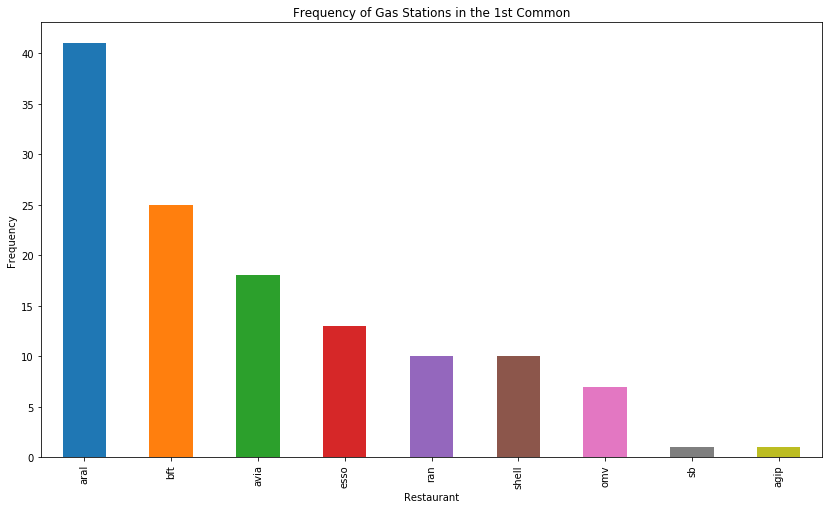

In [269]:
neighbourhoods_venues_sorted['1st Most Common Venue'].value_counts()
ax = neighbourhoods_venues_sorted['1st Most Common Venue'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Frequency of Gas Stations in the 1st Common Venue Column")
ax.set_xlabel("Restaurant")
ax.set_ylabel("Frequency")

Text(0,0.5,'Frequency')

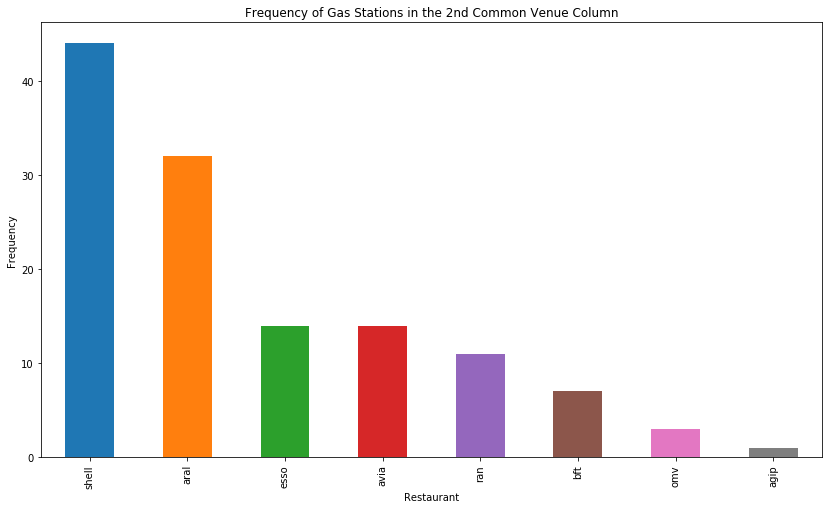

In [270]:
neighbourhoods_venues_sorted['2nd Most Common Venue'].value_counts()
ax = neighbourhoods_venues_sorted['2nd Most Common Venue'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Frequency of Gas Stations in the 2nd Common Venue Column")
ax.set_xlabel("Restaurant")
ax.set_ylabel("Frequency")

Text(0,0.5,'Frequency')

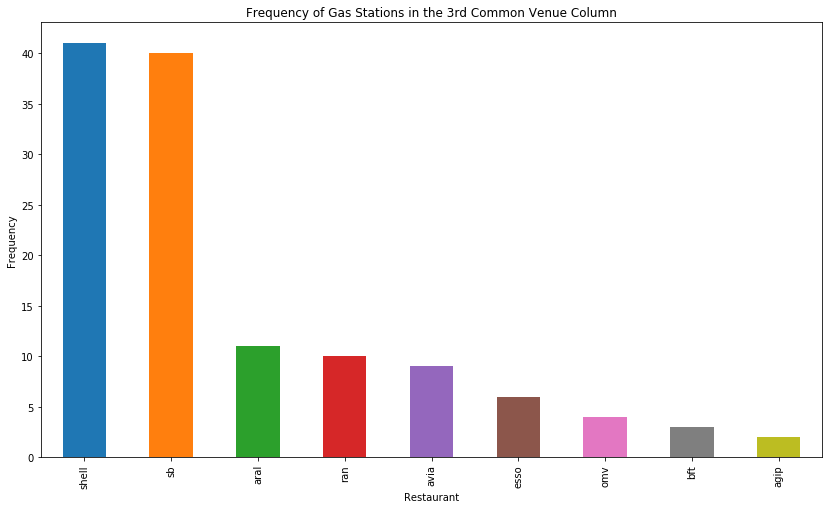

In [271]:
neighbourhoods_venues_sorted['3rd Most Common Venue'].value_counts()
ax = neighbourhoods_venues_sorted['3rd Most Common Venue'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Frequency of Gas Stations in the 3rd Common Venue Column")
ax.set_xlabel("Restaurant")
ax.set_ylabel("Frequency")

### Clustering Neighbourhoods According to most common gas station brands

In [336]:
# set number of clusters
kclusters = 3

filteredGas_df_grouped_clustering = filteredGas_df_grouped.drop('Community', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(filteredGas_df_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# scoring
print(kmeans.inertia_)

21.50112747779425


In [337]:
neighbourhoods_venues_sorted.drop(['Cluster Labels'],axis = 1,inplace = True)
# add clustering labels

neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

community_merged = communities_df

community_merged = pd.merge(left = neighbourhoods_venues_sorted, right = communities_df, left_on='Community', right_on='communityName')

community_merged.head() # check the last columns!

,Cluster Labels,Community,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,districtName,communityName,latitude,longitude,population m,population w,geometry.coordinates
0,0,Achberg,omv,aral,shell,bft,sb,Ravensburg,Achberg,47.615122,9.713856,879,864,1743
1,2,Achstetten,avia,ran,shell,sb,omv,Biberach,Achstetten,48.258983,9.898085,2473,2447,4920
2,1,Aichstetten,ran,aral,shell,sb,omv,Ravensburg,Aichstetten,47.892919,10.080670,1465,1341,2806
3,1,Aitrach,aral,shell,sb,ran,omv,Ravensburg,Aitrach,47.940739,10.083889,1422,1304,2726
4,2,Alleshausen,avia,shell,sb,ran,omv,Biberach,Alleshausen,48.102679,9.621543,270,254,524


In [338]:
import matplotlib.cm as cm
import matplotlib.colors as colors
# create map
map_clusters = folium.Map(location=[communities_df["latitude"].mean(),communities_df["longitude"].mean()],zoom_start=9)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster,dominatingGasStation in zip(community_merged['latitude'], community_merged['longitude'], community_merged['Community'], community_merged['Cluster Labels'],neighbourhoods_venues_sorted["1st Most Common Venue"]):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + ", Dominating Gas Station:" + dominatingGasStation, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

As you can see there are differen clusters visible based on the gas station brand dominance